# Per-Layer Energy Profiling for DistilBERT
## ESE 5390 Final Project: Layer-wise Energy Analysis

This notebook analyzes the energy consumption of each layer in DistilBERT (FP32 baseline).

**Goal**: Identify which layers consume the most energy to guide selective quantization strategies.

**Approach**:
1. Use PyTorch hooks to measure execution time per layer
2. Monitor GPU power during inference
3. Compute energy consumption per layer
4. Visualize energy hotspots in the model

## 1. Setup and Imports

In [19]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import json
import time
import subprocess
import threading
from pathlib import Path
from typing import Dict, List, Tuple
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA version: 12.4


## 2. Load Dataset

In [ ]:
# Auto-detect dataset path
import os

cwd = os.getcwd()
print(f"Current working directory: {cwd}")

# Check if we need to clone the repo (for Kaggle)
repo_path = Path(cwd) / "energy_aware_quantization"
if not repo_path.exists() and "kaggle" in cwd.lower():
    print("\n⚙️  Cloning repository (Kaggle environment detected)...")
    import subprocess
    result = subprocess.run(
        ["git", "clone", "https://github.com/krishkc5/energy_aware_quantization.git"],
        cwd=cwd,
        capture_output=True,
        text=True
    )
    if result.returncode == 0:
        print("✓ Repository cloned successfully")
    else:
        print(f"Warning: Could not clone repository: {result.stderr}")

possible_paths = [
    Path(cwd) / "energy_aware_quantization" / "datasets" / "sst2_tokenized_data",  # Kaggle after clone
    Path(cwd) / ".." / "datasets" / "sst2_tokenized_data",  # From notebooks/
    Path(cwd) / "datasets" / "sst2_tokenized_data",          # From repo root
    Path(cwd) / ".." / ".." / "datasets" / "sst2_tokenized_data",  # From deeper nesting
]

dataset_path = None
for path in possible_paths:
    abs_path = path.resolve()
    print(f"Trying: {abs_path}")
    if abs_path.exists() and (abs_path / "input_ids.pt").exists():
        dataset_path = str(abs_path)
        break

if dataset_path is None:
    current = Path(cwd)
    for _ in range(5):
        test_path = current / "datasets" / "sst2_tokenized_data"
        print(f"Trying: {test_path.resolve()}")
        if test_path.exists() and (test_path / "input_ids.pt").exists():
            dataset_path = str(test_path.resolve())
            break
        current = current.parent

if dataset_path is None:
    raise FileNotFoundError(
        f"Could not find dataset. Tried:\n" + 
        "\n".join([f"  - {p.resolve()}" for p in possible_paths]) +
        f"\n\nCurrent directory: {cwd}\n" +
        "Please ensure the dataset exists or the repository is cloned."
    )

print(f"\n✓ Found dataset at: {dataset_path}")

# Load dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = Path(dataset_path)

input_ids = torch.load(dataset_path / "input_ids.pt", map_location=device)
attention_mask = torch.load(dataset_path / "attention_mask.pt", map_location=device)
labels = torch.load(dataset_path / "labels.pt", map_location=device)

print(f"\n✓ Loaded dataset:")
print(f"  - Samples: {input_ids.shape[0]}")
print(f"  - Sequence length: {input_ids.shape[1]}")
print(f"  - Device: {input_ids.device}")

Current working directory: /kaggle/working
Trying: /kaggle/working/energy_aware_quantization/datasets/tokenized_data

✓ Found dataset at: /kaggle/working/energy_aware_quantization/datasets/tokenized_data

✓ Loaded dataset:
  - Samples: 50
  - Sequence length: 128
  - Device: cuda:0


## 3. Load DistilBERT Model

In [21]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

print(f"Loading {model_name}...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    torch_dtype=torch.float32
)
model = model.to(device)
model.eval()

print(f"\n✓ Model loaded")
print(f"  - Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Device: {next(model.parameters()).device}")

# Print model architecture
print(f"\n📋 Model Architecture:")
for name, module in model.named_children():
    print(f"  - {name}: {module.__class__.__name__}")

Loading distilbert-base-uncased-finetuned-sst-2-english...

✓ Model loaded
  - Parameters: 66,955,010
  - Device: cuda:0

📋 Model Architecture:
  - distilbert: DistilBertModel
  - pre_classifier: Linear
  - classifier: Linear
  - dropout: Dropout


## 4. Layer Profiler with Timing Hooks

We'll use PyTorch forward hooks to measure execution time for each layer.

In [22]:
class LayerProfiler:
    """
    Profile execution time of each layer using forward hooks.
    """
    
    def __init__(self, model: nn.Module, device: str = "cuda"):
        self.model = model
        self.device = device
        self.hooks = []
        self.layer_times = defaultdict(list)
        self.layer_names = []
        self.current_forward_start = None
        
        # Register hooks for all named modules
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward pre/post hooks on all layers."""
        
        def make_pre_hook(name):
            def pre_hook(module, input):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_start"].append(time.perf_counter())
            return pre_hook
        
        def make_post_hook(name):
            def post_hook(module, input, output):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_end"].append(time.perf_counter())
            return post_hook
        
        # Register hooks on important layers
        for name, module in self.model.named_modules():
            # Skip container modules and focus on actual computation layers
            if len(list(module.children())) == 0:  # Leaf modules only
                if isinstance(module, (nn.Linear, nn.LayerNorm, nn.Dropout, nn.GELU, nn.Embedding)):
                    self.layer_names.append(name)
                    hook_pre = module.register_forward_pre_hook(make_pre_hook(name))
                    hook_post = module.register_forward_hook(make_post_hook(name))
                    self.hooks.append(hook_pre)
                    self.hooks.append(hook_post)
        
        print(f"✓ Registered hooks on {len(self.layer_names)} layers")
    
    def reset(self):
        """Reset timing statistics."""
        self.layer_times.clear()
    
    def remove_hooks(self):
        """Remove all hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
    
    def get_layer_times(self) -> Dict[str, float]:
        """
        Compute average execution time per layer.
        
        Returns:
            Dictionary mapping layer name to average time in seconds
        """
        layer_avg_times = {}
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                layer_avg_times[name] = np.mean(durations)
        
        return layer_avg_times
    
    def get_layer_stats(self) -> pd.DataFrame:
        """
        Get detailed statistics for each layer.
        
        Returns:
            DataFrame with layer statistics
        """
        stats = []
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                
                stats.append({
                    "layer_name": name,
                    "mean_time_ms": np.mean(durations) * 1000,
                    "std_time_ms": np.std(durations) * 1000,
                    "min_time_ms": np.min(durations) * 1000,
                    "max_time_ms": np.max(durations) * 1000,
                    "total_time_s": np.sum(durations),
                    "num_calls": len(durations)
                })
        
        df = pd.DataFrame(stats)
        
        # Add percentage of total time
        if len(df) > 0:
            total_time = df["total_time_s"].sum()
            df["percent_total"] = (df["total_time_s"] / total_time) * 100
        
        return df.sort_values("total_time_s", ascending=False)


# Create profiler
profiler = LayerProfiler(model, device=device)

✓ Registered hooks on 67 layers


## 5. Power Monitor

Simple power monitoring using nvidia-smi.

In [23]:
class SimplePowerMonitor:
    """
    Simple power monitor using nvidia-smi.
    """
    
    def __init__(self, interval_ms: int = 50, gpu_id: int = 0):
        self.interval_ms = interval_ms
        self.gpu_id = gpu_id
        self.samples = []
        self.is_running = False
        self._thread = None
        self._lock = threading.Lock()
    
    def _poll(self):
        """Poll nvidia-smi for power readings."""
        interval_sec = self.interval_ms / 1000.0
        
        while self.is_running:
            try:
                result = subprocess.run(
                    ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits", f"--id={self.gpu_id}"],
                    capture_output=True, text=True, timeout=2
                )
                if result.returncode == 0:
                    power = float(result.stdout.strip())
                    with self._lock:
                        self.samples.append((time.perf_counter(), power))
            except:
                pass
            time.sleep(interval_sec)
    
    def start(self):
        """Start monitoring."""
        with self._lock:
            self.samples = []
            self.is_running = True
        
        self._thread = threading.Thread(target=self._poll, daemon=True)
        self._thread.start()
    
    def stop(self):
        """Stop monitoring."""
        self.is_running = False
        if self._thread:
            self._thread.join(timeout=2)
    
    def get_samples(self) -> List[Tuple[float, float]]:
        """Get (timestamp, power) samples."""
        with self._lock:
            return self.samples.copy()
    
    def get_mean_power(self) -> float:
        """Get mean power in Watts."""
        samples = self.get_samples()
        if len(samples) == 0:
            return 0.0
        return np.mean([p for _, p in samples])


power_monitor = SimplePowerMonitor(interval_ms=50)
print("✓ Power monitor initialized")

✓ Power monitor initialized


## 6. Run Profiling Inference

Run inference with layer profiling and power monitoring.

In [24]:
# Warmup
print("Warming up GPU...")
with torch.no_grad():
    for _ in range(50):
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
if device == "cuda":
    torch.cuda.synchronize()
print("✓ Warmup complete\n")

# Reset profiler
profiler.reset()

# Run profiling with power monitoring
num_iters = 100
print(f"Running {num_iters} profiling iterations...")

power_monitor.start()
time.sleep(0.3)  # Let power monitor stabilize

if device == "cuda":
    torch.cuda.synchronize()

start_time = time.perf_counter()

with torch.no_grad():
    for i in range(num_iters):
        _ = model(input_ids=input_ids, attention_mask=attention_mask)
        
        if (i + 1) % 20 == 0:
            print(f"  Progress: {i+1}/{num_iters}", end='\r')

if device == "cuda":
    torch.cuda.synchronize()

end_time = time.perf_counter()

time.sleep(0.3)  # Capture trailing power samples
power_monitor.stop()

total_time = end_time - start_time
mean_power = power_monitor.get_mean_power()

print(f"\n\n✓ Profiling complete")
print(f"  - Total time: {total_time:.3f}s")
print(f"  - Mean power: {mean_power:.2f}W")
print(f"  - Total energy: {mean_power * total_time:.3f}J")
print(f"  - Power samples: {len(power_monitor.get_samples())}")

Warming up GPU...
✓ Warmup complete

Running 100 profiling iterations...
  Progress: 100/100

✓ Profiling complete
  - Total time: 9.348s
  - Mean power: 206.52W
  - Total energy: 1930.419J
  - Power samples: 125


## 7. Analyze Per-Layer Timing

In [25]:
# Get layer statistics
layer_stats = profiler.get_layer_stats()

print("\n" + "="*80)
print("PER-LAYER TIMING STATISTICS (Top 20)")
print("="*80)
print(layer_stats.head(20).to_string(index=False))
print("="*80)

# Save to CSV
output_dir = Path("../results")
output_dir.mkdir(parents=True, exist_ok=True)
layer_stats.to_csv(output_dir / "per_layer_timing_fp32.csv", index=False)
print(f"\n✓ Saved layer timing to: {output_dir / 'per_layer_timing_fp32.csv'}")


PER-LAYER TIMING STATISTICS (Top 20)
                                      layer_name  mean_time_ms  std_time_ms  min_time_ms  max_time_ms  total_time_s  num_calls  percent_total
         distilbert.transformer.layer.4.ffn.lin2      4.314471     0.054851     4.178209     4.425140      0.431447        100       5.237338
         distilbert.transformer.layer.3.ffn.lin2      4.313577     0.058498     4.176473     4.404544      0.431358        100       5.236253
         distilbert.transformer.layer.1.ffn.lin2      4.312669     0.059604     4.180194     4.474486      0.431267        100       5.235150
         distilbert.transformer.layer.2.ffn.lin2      4.309889     0.059337     4.171495     4.413463      0.430989        100       5.231776
         distilbert.transformer.layer.0.ffn.lin2      4.305410     0.059658     4.167399     4.404056      0.430541        100       5.226339
         distilbert.transformer.layer.5.ffn.lin2      4.299633     0.061487     4.175759     4.384524      0.4

## 8. Compute Per-Layer Energy Consumption

Estimate energy per layer using:
- Layer execution time (from profiling)
- Mean GPU power (from power monitor)

**Energy per layer = (Layer time / Total time) × Total energy**

In [26]:
# Compute per-layer energy
total_energy = mean_power * total_time  # Joules
total_measured_time = layer_stats["total_time_s"].sum()

layer_stats["energy_j"] = (layer_stats["total_time_s"] / total_measured_time) * total_energy
layer_stats["energy_mj"] = layer_stats["energy_j"] * 1000
layer_stats["energy_per_call_mj"] = layer_stats["energy_mj"] / layer_stats["num_calls"]

# Sort by energy consumption
layer_stats = layer_stats.sort_values("energy_j", ascending=False)

print("\n" + "="*100)
print("PER-LAYER ENERGY CONSUMPTION (Top 20)")
print("="*100)
print(layer_stats[["layer_name", "mean_time_ms", "energy_mj", "energy_per_call_mj", "percent_total"]].head(20).to_string(index=False))
print("="*100)

# Save to CSV
layer_stats.to_csv(output_dir / "per_layer_energy_fp32.csv", index=False)
print(f"\n✓ Saved layer energy to: {output_dir / 'per_layer_energy_fp32.csv'}")


PER-LAYER ENERGY CONSUMPTION (Top 20)
                                      layer_name  mean_time_ms     energy_mj  energy_per_call_mj  percent_total
         distilbert.transformer.layer.4.ffn.lin2      4.314471 101102.572610         1011.025726       5.237338
         distilbert.transformer.layer.3.ffn.lin2      4.313577 101081.615920         1010.816159       5.236253
         distilbert.transformer.layer.1.ffn.lin2      4.312669 101060.330693         1010.603307       5.235150
         distilbert.transformer.layer.2.ffn.lin2      4.309889 100995.186882         1009.951869       5.231776
         distilbert.transformer.layer.0.ffn.lin2      4.305410 100890.231663         1008.902317       5.226339
         distilbert.transformer.layer.5.ffn.lin2      4.299633 100754.869077         1007.548691       5.219327
         distilbert.transformer.layer.0.ffn.lin1      4.281913 100339.622860         1003.396229       5.197816
         distilbert.transformer.layer.1.ffn.lin1      4.280222 10

## 9. Group Energy by Layer Type

In [27]:
# Extract layer type from name
def get_layer_type(name: str) -> str:
    """Extract layer type from full layer name."""
    if "attention.q_lin" in name or "attention.k_lin" in name or "attention.v_lin" in name:
        return "Attention Projection"
    elif "attention.out_lin" in name:
        return "Attention Output"
    elif "ffn.lin1" in name:
        return "FFN Layer 1"
    elif "ffn.lin2" in name:
        return "FFN Layer 2"
    elif "sa_layer_norm" in name or "output_layer_norm" in name:
        return "LayerNorm"
    elif "embeddings" in name:
        return "Embeddings"
    elif "pre_classifier" in name or "classifier" in name:
        return "Classifier"
    elif "dropout" in name:
        return "Dropout"
    else:
        return "Other"

layer_stats["layer_type"] = layer_stats["layer_name"].apply(get_layer_type)

# Group by layer type
type_energy = layer_stats.groupby("layer_type").agg({
    "energy_j": "sum",
    "energy_mj": "sum",
    "total_time_s": "sum",
    "layer_name": "count"
}).rename(columns={"layer_name": "num_layers"})

type_energy["percent_energy"] = (type_energy["energy_j"] / type_energy["energy_j"].sum()) * 100
type_energy = type_energy.sort_values("energy_j", ascending=False)

print("\n" + "="*80)
print("ENERGY CONSUMPTION BY LAYER TYPE")
print("="*80)
print(type_energy.to_string())
print("="*80)

# Save to CSV
type_energy.to_csv(output_dir / "energy_by_layer_type_fp32.csv")
print(f"\n✓ Saved grouped energy to: {output_dir / 'energy_by_layer_type_fp32.csv'}")


ENERGY CONSUMPTION BY LAYER TYPE
                        energy_j      energy_mj  total_time_s  num_layers  percent_energy
layer_type                                                                               
FFN Layer 2           605.884807  605884.806845      2.585565           6       31.386183
FFN Layer 1           601.777821  601777.820859      2.568039           6       31.173432
Attention Projection  491.061500  491061.499819      2.095566          18       25.438080
Attention Output      164.183591  164183.590678      0.700640           6        8.505076
LayerNorm              46.366984   46366.984166      0.197867          12        2.401913
Embeddings             12.084420   12084.420424      0.051569           4        0.626000
Dropout                 4.943264    4943.264119      0.021095           7        0.256072
Classifier              4.116533    4116.532738      0.017567           2        0.213246

✓ Saved grouped energy to: ../results/energy_by_layer_type_fp32.c

## 10. Visualizations


✓ Saved plots to: ../results/per_layer_energy_analysis_fp32.png


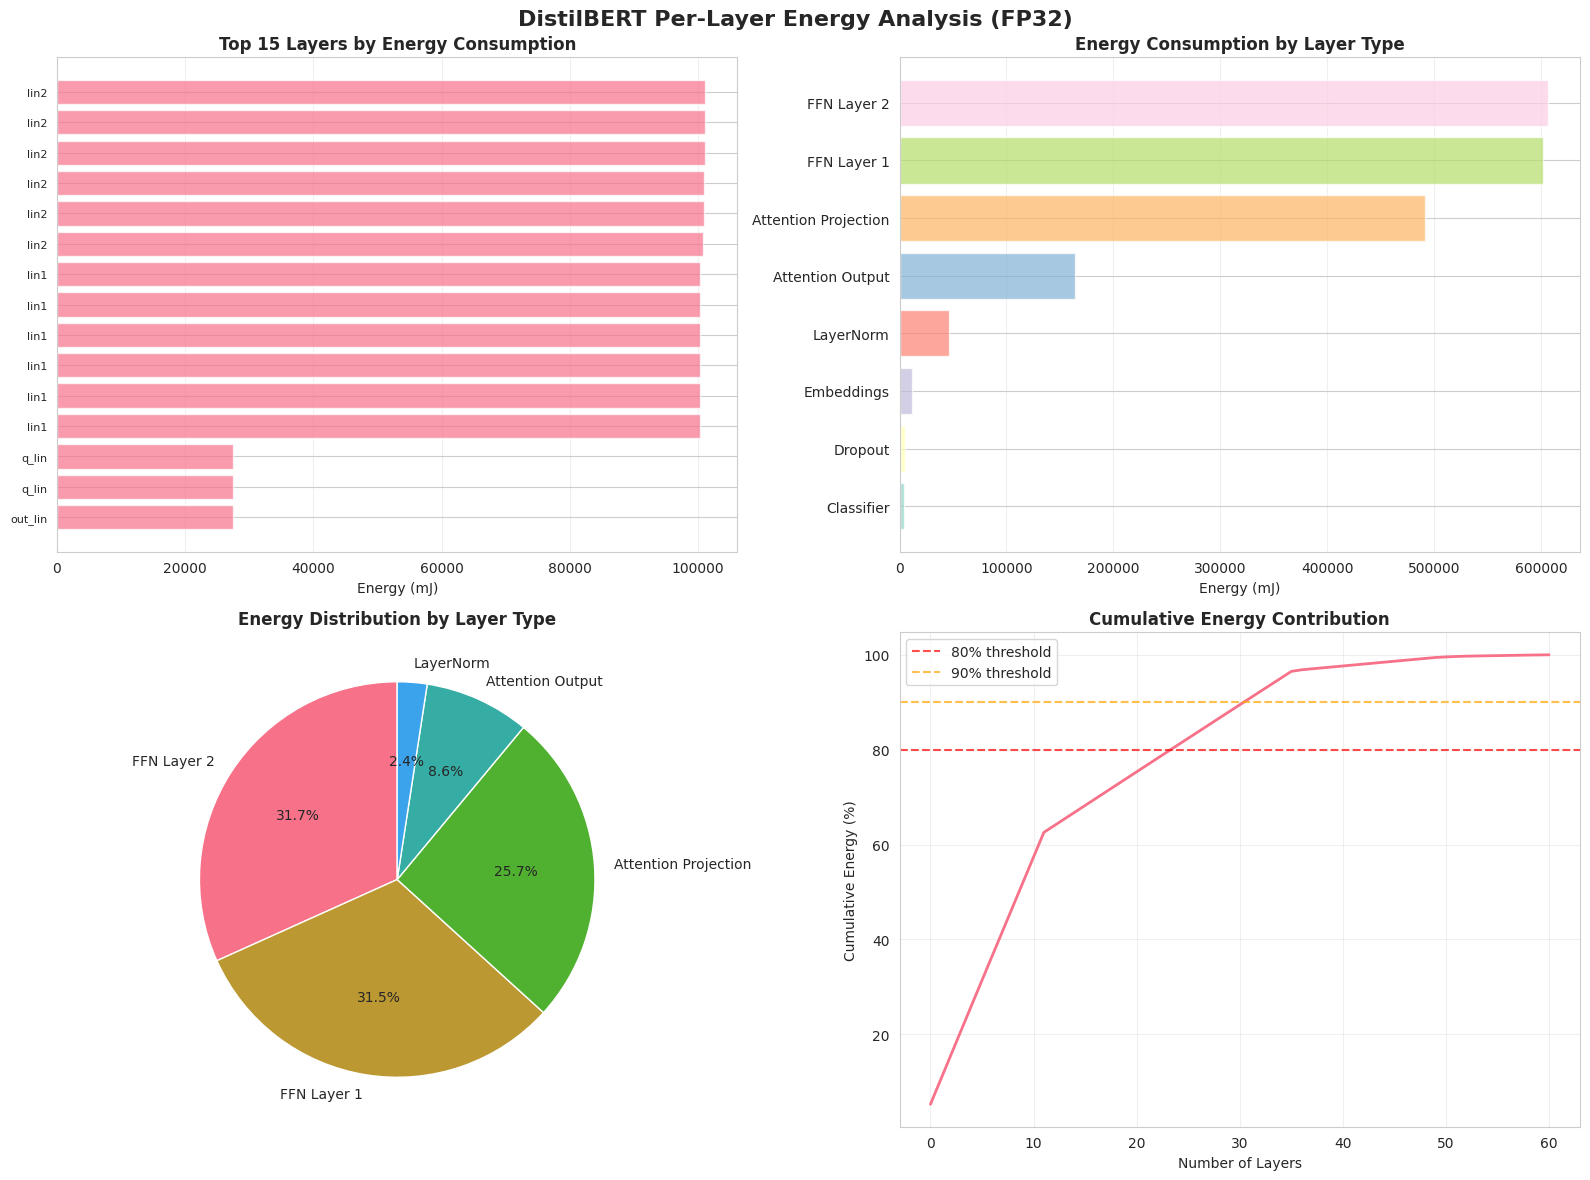

In [28]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("DistilBERT Per-Layer Energy Analysis (FP32)", fontsize=16, fontweight='bold')

# 1. Top 15 layers by energy
ax = axes[0, 0]
top_layers = layer_stats.head(15)
y_pos = range(len(top_layers))
ax.barh(y_pos, top_layers["energy_mj"], alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels([name.split('.')[-1] if len(name.split('.')) > 1 else name for name in top_layers["layer_name"]], fontsize=8)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Top 15 Layers by Energy Consumption", fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# 2. Energy by layer type
ax = axes[0, 1]
type_energy_sorted = type_energy.sort_values("energy_mj", ascending=True)
y_pos = range(len(type_energy_sorted))
colors = plt.cm.Set3(range(len(type_energy_sorted)))
ax.barh(y_pos, type_energy_sorted["energy_mj"], alpha=0.7, color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_energy_sorted.index, fontsize=10)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Energy Consumption by Layer Type", fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Pie chart of energy distribution
ax = axes[1, 0]
type_energy_pie = type_energy[type_energy["percent_energy"] > 1.0]  # Show only >1%
ax.pie(type_energy_pie["percent_energy"], labels=type_energy_pie.index, autopct='%1.1f%%', startangle=90)
ax.set_title("Energy Distribution by Layer Type", fontsize=12, fontweight='bold')

# 4. Cumulative energy contribution
ax = axes[1, 1]
cumulative = layer_stats["energy_mj"].cumsum() / layer_stats["energy_mj"].sum() * 100
ax.plot(range(len(cumulative)), cumulative, linewidth=2)
ax.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
ax.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax.set_xlabel("Number of Layers", fontsize=10)
ax.set_ylabel("Cumulative Energy (%)", fontsize=10)
ax.set_title("Cumulative Energy Contribution", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plot_path = output_dir / "per_layer_energy_analysis_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved plots to: {plot_path}")
plt.show()

## 11. Key Insights

Identify the most energy-hungry layers for targeted quantization.

In [29]:
# Find how many layers account for 80% of energy
cumulative_energy = layer_stats["energy_j"].cumsum() / layer_stats["energy_j"].sum()
layers_for_80_pct = (cumulative_energy <= 0.80).sum()
layers_for_90_pct = (cumulative_energy <= 0.90).sum()

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print(f"\n📊 Energy Distribution:")
print(f"  - Total layers profiled: {len(layer_stats)}")
print(f"  - Layers accounting for 80% of energy: {layers_for_80_pct} ({layers_for_80_pct/len(layer_stats)*100:.1f}%)")
print(f"  - Layers accounting for 90% of energy: {layers_for_90_pct} ({layers_for_90_pct/len(layer_stats)*100:.1f}%)")

print(f"\n🔥 Top Energy Consumers:")
top_3 = layer_stats.head(3)
for i, row in top_3.iterrows():
    print(f"  {row['layer_name']}:")
    print(f"    - Energy: {row['energy_mj']:.2f} mJ ({row['percent_total']:.1f}% of total)")
    print(f"    - Avg time: {row['mean_time_ms']:.3f} ms per call")

print(f"\n🎯 Quantization Strategy Recommendations:")
print(f"  1. Prioritize quantizing: {type_energy.head(3).index.tolist()}")
print(f"  2. These layer types account for {type_energy.head(3)['percent_energy'].sum():.1f}% of total energy")
print(f"  3. Consider keeping embeddings and LayerNorm in higher precision")

print("\n" + "="*80)


KEY INSIGHTS

📊 Energy Distribution:
  - Total layers profiled: 61
  - Layers accounting for 80% of energy: 24 (39.3%)
  - Layers accounting for 90% of energy: 31 (50.8%)

🔥 Top Energy Consumers:
  distilbert.transformer.layer.4.ffn.lin2:
    - Energy: 101102.57 mJ (5.2% of total)
    - Avg time: 4.314 ms per call
  distilbert.transformer.layer.3.ffn.lin2:
    - Energy: 101081.62 mJ (5.2% of total)
    - Avg time: 4.314 ms per call
  distilbert.transformer.layer.1.ffn.lin2:
    - Energy: 101060.33 mJ (5.2% of total)
    - Avg time: 4.313 ms per call

🎯 Quantization Strategy Recommendations:
  1. Prioritize quantizing: ['FFN Layer 2', 'FFN Layer 1', 'Attention Projection']
  2. These layer types account for 88.0% of total energy
  3. Consider keeping embeddings and LayerNorm in higher precision



## 12. Export Summary Report

In [30]:
# Create summary report
summary_report = {
    "model_name": model_name,
    "precision": "fp32",
    "num_profiling_iterations": num_iters,
    "total_time_s": float(total_time),
    "mean_power_w": float(mean_power),
    "total_energy_j": float(total_energy),
    "num_layers_profiled": len(layer_stats),
    "layers_for_80pct_energy": int(layers_for_80_pct),
    "layers_for_90pct_energy": int(layers_for_90_pct),
    "top_energy_layer": layer_stats.iloc[0]["layer_name"],
    "top_energy_layer_mj": float(layer_stats.iloc[0]["energy_mj"]),
    "top_energy_layer_percent": float(layer_stats.iloc[0]["percent_total"]),
    "energy_by_type": type_energy.to_dict(),
}

# Save as JSON
report_path = output_dir / "per_layer_energy_summary_fp32.json"
with open(report_path, 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"✓ Saved summary report to: {report_path}")

# Clean up
profiler.remove_hooks()
print("\n✓ Profiling complete and hooks removed")

✓ Saved summary report to: ../results/per_layer_energy_summary_fp32.json

✓ Profiling complete and hooks removed


## 13. Per-Layer Accuracy Impact Analysis

Measure accuracy impact of quantizing each layer individually to FP16.
This helps identify layers that:
- **High energy consumption** (from previous analysis)
- **Low accuracy impact** (quantization-friendly)

We'll create a correlation matrix to visualize the tradeoff.


In [ ]:
def evaluate_accuracy(model, input_ids, attention_mask, labels, batch_size=8):
    """
    Evaluate model accuracy on the dataset.
    
    Returns:
        accuracy: float (0-1)
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i in range(0, len(input_ids), batch_size):
            end_idx = min(i + batch_size, len(input_ids))
            batch_input_ids = input_ids[i:end_idx]
            batch_attention_mask = attention_mask[i:end_idx]
            batch_labels = labels[i:end_idx]
            
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            
            correct += (predictions == batch_labels).sum().item()
            total += len(batch_labels)
    
    return correct / total if total > 0 else 0.0


def quantize_layer_to_fp16(model, layer_name):
    """
    Quantize a specific layer to FP16 while keeping the rest in FP32.
    
    Args:
        model: The model to modify
        layer_name: Full name of the layer (e.g., "distilbert.transformer.layer.0.ffn.lin1")
    
    Returns:
        Modified model (in-place modification)
    """
    # Get the layer module using getattr recursively
    parts = layer_name.split('.')
    parent = model
    for part in parts[:-1]:
        parent = getattr(parent, part)
    
    # Get the actual layer module
    layer_part = parts[-1]
    module = getattr(parent, layer_part)
    
    # Convert layer to FP16 by converting its parameters
    if isinstance(module, (nn.Linear, nn.LayerNorm)):
        # Convert all parameters and buffers to FP16
        module.to(torch.float16)
    elif isinstance(module, nn.Embedding):
        # Embeddings typically stay in FP32 for stability
        pass
    
    return model


def restore_layer_to_fp32(model, layer_name):
    """
    Restore a specific layer back to FP32.
    
    Args:
        model: The model to modify
        layer_name: Full name of the layer
    """
    parts = layer_name.split('.')
    parent = model
    for part in parts[:-1]:
        parent = getattr(parent, part)
    
    layer_part = parts[-1]
    module = getattr(parent, layer_part)
    
    # Convert layer back to FP32
    if isinstance(module, (nn.Linear, nn.LayerNorm)):
        module.to(torch.float32)
    
    return model


print("✓ Accuracy evaluation and layer quantization functions defined")


In [ ]:
# Measure baseline FP32 accuracy
print("Measuring baseline FP32 accuracy...")
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    torch_dtype=torch.float32
)
baseline_model = baseline_model.to(device)
baseline_model.eval()

baseline_accuracy = evaluate_accuracy(baseline_model, input_ids, attention_mask, labels)
print(f"✓ Baseline FP32 accuracy: {baseline_accuracy*100:.2f}%")

# Filter to only quantizable layers (Linear layers that consume significant energy)
quantizable_layers = layer_stats[
    (layer_stats["energy_mj"] > 1000) &  # Only layers with significant energy
    (layer_stats["layer_name"].str.contains("lin"))  # Only Linear layers
].copy()

print(f"\n✓ Found {len(quantizable_layers)} quantizable layers to analyze")
print(f"  (Layers with energy > 1000 mJ and are Linear layers)")


In [ ]:
# Measure accuracy impact for each layer
print("\n" + "="*80)
print("MEASURING ACCURACY IMPACT PER LAYER")
print("="*80)
print("This will quantize each layer individually and measure accuracy change.\n")

accuracy_impacts = []

for idx, row in quantizable_layers.iterrows():
    layer_name = row["layer_name"]
    energy_mj = row["energy_mj"]
    
    print(f"[{len(accuracy_impacts)+1}/{len(quantizable_layers)}] Testing: {layer_name.split('.')[-1]}...", end=' ')
    
    # Create a fresh model copy
    test_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        torch_dtype=torch.float32
    )
    test_model = test_model.to(device)
    test_model.eval()
    
    # Quantize only this layer to FP16
    try:
        quantize_layer_to_fp16(test_model, layer_name)
        
        # Measure accuracy
        quantized_accuracy = evaluate_accuracy(test_model, input_ids, attention_mask, labels)
        accuracy_drop = baseline_accuracy - quantized_accuracy
        accuracy_drop_pct = accuracy_drop * 100
        
        accuracy_impacts.append({
            "layer_name": layer_name,
            "energy_mj": energy_mj,
            "baseline_accuracy": baseline_accuracy,
            "quantized_accuracy": quantized_accuracy,
            "accuracy_drop": accuracy_drop,
            "accuracy_drop_pct": accuracy_drop_pct
        })
        
        print(f"✓ Accuracy: {quantized_accuracy*100:.2f}% (drop: {accuracy_drop_pct:.2f}%)")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        accuracy_impacts.append({
            "layer_name": layer_name,
            "energy_mj": energy_mj,
            "baseline_accuracy": baseline_accuracy,
            "quantized_accuracy": baseline_accuracy,  # Assume no change on error
            "accuracy_drop": 0.0,
            "accuracy_drop_pct": 0.0
        })

print(f"\n✓ Completed accuracy impact analysis for {len(accuracy_impacts)} layers")


In [ ]:
# Combine energy and accuracy data
accuracy_df = pd.DataFrame(accuracy_impacts)

# Merge with layer_stats to get all layer information
layer_analysis = quantizable_layers.merge(
    accuracy_df[["layer_name", "quantized_accuracy", "accuracy_drop", "accuracy_drop_pct"]],
    on="layer_name",
    how="left"
)

# Calculate quantization score: high energy, low accuracy impact = good candidate
# Score = energy_mj / (1 + abs(accuracy_drop_pct))
# Higher score = better candidate for quantization
layer_analysis["quantization_score"] = layer_analysis["energy_mj"] / (1 + layer_analysis["accuracy_drop_pct"].abs())

# Sort by quantization score (best candidates first)
layer_analysis = layer_analysis.sort_values("quantization_score", ascending=False)

print("\n" + "="*80)
print("LAYER QUANTIZATION ANALYSIS (Top 20 by Score)")
print("="*80)
print("Score = Energy / (1 + |Accuracy Drop|) - Higher is better")
print("="*80)
display_cols = ["layer_name", "energy_mj", "accuracy_drop_pct", "quantization_score", "layer_type"]
print(layer_analysis[display_cols].head(20).to_string(index=False))
print("="*80)

# Save to CSV
layer_analysis.to_csv(output_dir / "layer_quantization_analysis.csv", index=False)
print(f"\n✓ Saved layer quantization analysis to: {output_dir / 'layer_quantization_analysis.csv'}")


## 14. Correlation Matrix Visualization

Create correlation matrix and scatter plots to visualize the energy vs accuracy tradeoff.


In [ ]:
# Prepare data for correlation matrix
correlation_data = layer_analysis[["energy_mj", "accuracy_drop_pct", "quantization_score", "mean_time_ms"]].copy()

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)
print(correlation_matrix.round(3))
print("="*80)


In [ ]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Correlation Matrix Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax1
)
ax1.set_title("Correlation Matrix\n(Energy vs Accuracy Impact)", fontsize=12, fontweight='bold')

# 2. Energy vs Accuracy Drop Scatter
ax2 = fig.add_subplot(gs[0, 1])
scatter = ax2.scatter(
    layer_analysis["energy_mj"],
    layer_analysis["accuracy_drop_pct"],
    c=layer_analysis["quantization_score"],
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax2.set_xlabel("Energy Consumption (mJ)", fontsize=11, fontweight='bold')
ax2.set_ylabel("Accuracy Drop (%)", fontsize=11, fontweight='bold')
ax2.set_title("Energy vs Accuracy Tradeoff", fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Quantization Score')

# Add quadrant labels
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax2.axvline(x=layer_analysis["energy_mj"].median(), color='r', linestyle='--', alpha=0.5, linewidth=1)
ax2.text(0.05, 0.95, "High Energy\nLow Impact\n(OPTIMAL)", 
         transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
ax2.text(0.95, 0.05, "Low Energy\nHigh Impact\n(AVOID)", 
         transform=ax2.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

# 3. Top Layers by Quantization Score
ax3 = fig.add_subplot(gs[0, 2])
top_score_layers = layer_analysis.head(15)
y_pos = range(len(top_score_layers))
colors = plt.cm.viridis(top_score_layers["quantization_score"] / top_score_layers["quantization_score"].max())
ax3.barh(y_pos, top_score_layers["quantization_score"], color=colors, alpha=0.7, edgecolor='black')
ax3.set_yticks(y_pos)
ax3.set_yticklabels([name.split('.')[-1] for name in top_score_layers["layer_name"]], fontsize=8)
ax3.set_xlabel("Quantization Score", fontsize=10, fontweight='bold')
ax3.set_title("Top 15 Layers by\nQuantization Score", fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Energy Distribution by Layer Type (with accuracy impact)
ax4 = fig.add_subplot(gs[1, :2])
type_analysis = layer_analysis.groupby("layer_type").agg({
    "energy_mj": "sum",
    "accuracy_drop_pct": "mean",
    "quantization_score": "sum"
}).sort_values("energy_mj", ascending=False)

x_pos = range(len(type_analysis))
width = 0.35
ax4_twin = ax4.twinx()

bars1 = ax4.bar([x - width/2 for x in x_pos], type_analysis["energy_mj"], 
                width, label='Total Energy (mJ)', alpha=0.7, color='steelblue')
bars2 = ax4_twin.bar([x + width/2 for x in x_pos], type_analysis["accuracy_drop_pct"].abs(), 
                     width, label='Avg Accuracy Drop (%)', alpha=0.7, color='coral')

ax4.set_xlabel("Layer Type", fontsize=11, fontweight='bold')
ax4.set_ylabel("Total Energy (mJ)", fontsize=11, fontweight='bold', color='steelblue')
ax4_twin.set_ylabel("Avg Accuracy Drop (%)", fontsize=11, fontweight='bold', color='coral')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(type_analysis.index, rotation=45, ha='right', fontsize=9)
ax4.set_title("Energy and Accuracy Impact by Layer Type", fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

# 5. Quantization Score Distribution
ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(layer_analysis["quantization_score"], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
ax5.set_xlabel("Quantization Score", fontsize=10, fontweight='bold')
ax5.set_ylabel("Number of Layers", fontsize=10, fontweight='bold')
ax5.set_title("Quantization Score\nDistribution", fontsize=12, fontweight='bold')
ax5.axvline(layer_analysis["quantization_score"].median(), color='r', linestyle='--', 
            label=f'Median: {layer_analysis["quantization_score"].median():.0f}')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Energy vs Time (with accuracy impact as color)
ax6 = fig.add_subplot(gs[2, 0])
scatter2 = ax6.scatter(
    layer_analysis["mean_time_ms"],
    layer_analysis["energy_mj"],
    c=layer_analysis["accuracy_drop_pct"].abs(),
    cmap='Reds',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax6.set_xlabel("Mean Time (ms)", fontsize=11, fontweight='bold')
ax6.set_ylabel("Energy (mJ)", fontsize=11, fontweight='bold')
ax6.set_title("Time vs Energy\n(Color = Accuracy Impact)", fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax6, label='|Accuracy Drop| (%)')

# 7. Cumulative Energy vs Cumulative Accuracy Impact
ax7 = fig.add_subplot(gs[2, 1])
sorted_by_score = layer_analysis.sort_values("quantization_score", ascending=False)
cumulative_energy = sorted_by_score["energy_mj"].cumsum() / sorted_by_score["energy_mj"].sum() * 100
cumulative_acc_drop = sorted_by_score["accuracy_drop_pct"].abs().cumsum()

ax7.plot(range(len(cumulative_energy)), cumulative_energy, 'b-', linewidth=2, label='Cumulative Energy (%)')
ax7_twin = ax7.twinx()
ax7_twin.plot(range(len(cumulative_acc_drop)), cumulative_acc_drop, 'r-', linewidth=2, label='Cumulative |Accuracy Drop| (%)')

ax7.set_xlabel("Number of Layers (sorted by score)", fontsize=11, fontweight='bold')
ax7.set_ylabel("Cumulative Energy (%)", fontsize=11, fontweight='bold', color='blue')
ax7_twin.set_ylabel("Cumulative |Accuracy Drop| (%)", fontsize=11, fontweight='bold', color='red')
ax7.set_title("Cumulative Impact\n(Sorted by Quantization Score)", fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)
ax7.legend(loc='upper left')
ax7_twin.legend(loc='upper right')

# 8. Layer Type Quantization Score Comparison
ax8 = fig.add_subplot(gs[2, 2])
type_scores = layer_analysis.groupby("layer_type")["quantization_score"].sum().sort_values(ascending=True)
y_pos = range(len(type_scores))
colors = plt.cm.viridis(type_scores / type_scores.max())
ax8.barh(y_pos, type_scores, color=colors, alpha=0.7, edgecolor='black')
ax8.set_yticks(y_pos)
ax8.set_yticklabels(type_scores.index, fontsize=9)
ax8.set_xlabel("Total Quantization Score", fontsize=10, fontweight='bold')
ax8.set_title("Quantization Score\nby Layer Type", fontsize=12, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(axis='x', alpha=0.3)

fig.suptitle("DistilBERT: Energy vs Accuracy Tradeoff Analysis", fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plot_path = output_dir / "energy_accuracy_tradeoff_analysis.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved comprehensive analysis plots to: {plot_path}")
plt.show()


## 15. Identify Optimal Layers for Quantization

Select layers with high energy consumption and low accuracy impact.


In [ ]:
# Define selection criteria for optimal layers
# 1. High energy consumption (top 50% by energy)
# 2. Low accuracy impact (accuracy drop < threshold)
# 3. High quantization score

energy_threshold = layer_analysis["energy_mj"].quantile(0.5)  # Top 50% by energy
accuracy_threshold = 1.0  # Accept up to 1% accuracy drop per layer

optimal_layers = layer_analysis[
    (layer_analysis["energy_mj"] >= energy_threshold) &
    (layer_analysis["accuracy_drop_pct"].abs() <= accuracy_threshold)
].copy()

# Sort by quantization score
optimal_layers = optimal_layers.sort_values("quantization_score", ascending=False)

print("\n" + "="*80)
print("OPTIMAL LAYERS FOR QUANTIZATION")
print("="*80)
print(f"Selection Criteria:")
print(f"  - Energy >= {energy_threshold:.0f} mJ (top 50%)")
print(f"  - Accuracy drop <= {accuracy_threshold:.2f}%")
print(f"  - Total candidates: {len(optimal_layers)} layers")
print("="*80)
print("\nTop 20 Optimal Layers:")
display_cols = ["layer_name", "layer_type", "energy_mj", "accuracy_drop_pct", "quantization_score"]
print(optimal_layers[display_cols].head(20).to_string(index=False))
print("="*80)

# Calculate potential energy savings
total_energy = layer_analysis["energy_mj"].sum()
optimal_energy = optimal_layers["energy_mj"].sum()
energy_savings_pct = (optimal_energy / total_energy) * 100

total_acc_drop = optimal_layers["accuracy_drop_pct"].abs().sum()

print(f"\n📊 Quantization Impact Projection:")
print(f"  - Energy covered: {optimal_energy:.0f} mJ ({energy_savings_pct:.1f}% of total)")
print(f"  - Expected accuracy drop: {total_acc_drop:.2f}%")
print(f"  - Number of layers to quantize: {len(optimal_layers)}")

# Save optimal layers list
optimal_layers.to_csv(output_dir / "optimal_layers_for_quantization.csv", index=False)
print(f"\n✓ Saved optimal layers list to: {output_dir / 'optimal_layers_for_quantization.csv'}")


## 16. Benchmark: Quantize Optimal Layers to FP16

Create a selectively quantized model and benchmark it against FP32 baseline.


In [ ]:
def create_selectively_quantized_model(model, layers_to_quantize):
    """
    Create a copy of the model with specified layers quantized to FP16.
    
    Args:
        model: Base FP32 model
        layers_to_quantize: List of layer names to quantize
    
    Returns:
        Selectively quantized model
    """
    # Create a fresh copy
    quantized_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        torch_dtype=torch.float32
    )
    quantized_model = quantized_model.to(device)
    quantized_model.eval()
    
    # Quantize specified layers
    for layer_name in layers_to_quantize:
        try:
            quantize_layer_to_fp16(quantized_model, layer_name)
        except Exception as e:
            print(f"Warning: Could not quantize {layer_name}: {e}")
    
    return quantized_model


# Select top N layers by quantization score
num_layers_to_quantize = min(20, len(optimal_layers))  # Quantize top 20 optimal layers
top_optimal_layers = optimal_layers.head(num_layers_to_quantize)["layer_name"].tolist()

print(f"\nCreating selectively quantized model...")
print(f"  - Quantizing {len(top_optimal_layers)} optimal layers to FP16")
print(f"  - Selected layers:")
for i, layer in enumerate(top_optimal_layers[:10], 1):
    print(f"    {i}. {layer.split('.')[-1]}")
if len(top_optimal_layers) > 10:
    print(f"    ... and {len(top_optimal_layers) - 10} more")

selective_model = create_selectively_quantized_model(model, top_optimal_layers)
print(f"\n✓ Selectively quantized model created")


In [ ]:
def benchmark_model(model, model_name_str, input_ids, attention_mask, labels, num_iterations=100, batch_size=8):
    """
    Comprehensive benchmark: accuracy, latency, and energy.
    
    Returns:
        Dictionary with benchmark results
    """
    model.eval()
    
    # Warmup
    print(f"  Warming up...")
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_ids=input_ids[:batch_size], attention_mask=attention_mask[:batch_size])
    if device == "cuda":
        torch.cuda.synchronize()
    
    # Measure accuracy
    print(f"  Measuring accuracy...")
    accuracy = evaluate_accuracy(model, input_ids, attention_mask, labels, batch_size)
    
    # Measure latency and energy
    print(f"  Measuring latency and energy ({num_iterations} iterations)...")
    
    power_monitor.start()
    time.sleep(0.3)
    
    if device == "cuda":
        torch.cuda.synchronize()
    
    latencies = []
    start_time = time.perf_counter()
    
    with torch.no_grad():
        for i in range(num_iterations):
            batch_start = time.perf_counter()
            _ = model(input_ids=input_ids[:batch_size], attention_mask=attention_mask[:batch_size])
            if device == "cuda":
                torch.cuda.synchronize()
            batch_end = time.perf_counter()
            latencies.append(batch_end - batch_start)
    
    end_time = time.perf_counter()
    time.sleep(0.3)
    power_monitor.stop()
    
    total_time = end_time - start_time
    mean_power = power_monitor.get_mean_power()
    total_energy = mean_power * total_time
    mean_latency = np.mean(latencies) * 1000  # ms
    
    results = {
        "model_name": model_name_str,
        "accuracy": accuracy * 100,
        "mean_latency_ms": mean_latency,
        "std_latency_ms": np.std(latencies) * 1000,
        "total_time_s": total_time,
        "mean_power_w": mean_power,
        "total_energy_j": total_energy,
        "energy_per_sample_mj": (total_energy / (num_iterations * batch_size)) * 1000
    }
    
    return results


print("\n" + "="*80)
print("BENCHMARKING MODELS")
print("="*80)

# Benchmark FP32 baseline
print("\n[1/2] Benchmarking FP32 Baseline...")
baseline_results = benchmark_model(
    baseline_model, 
    "FP32 Baseline",
    input_ids, 
    attention_mask, 
    labels,
    num_iterations=100
)

# Benchmark selectively quantized model
print("\n[2/2] Benchmarking Selectively Quantized Model (FP16 on optimal layers)...")
selective_results = benchmark_model(
    selective_model,
    "Selective FP16",
    input_ids,
    attention_mask,
    labels,
    num_iterations=100
)

print("\n✓ Benchmarking complete")


In [ ]:
# Compare results
comparison_df = pd.DataFrame([baseline_results, selective_results])

print("\n" + "="*80)
print("BENCHMARK RESULTS COMPARISON")
print("="*80)
print(comparison_df[["model_name", "accuracy", "mean_latency_ms", "mean_power_w", "energy_per_sample_mj"]].to_string(index=False))
print("="*80)

# Calculate improvements
accuracy_change = selective_results["accuracy"] - baseline_results["accuracy"]
latency_speedup = baseline_results["mean_latency_ms"] / selective_results["mean_latency_ms"]
energy_reduction = (1 - selective_results["energy_per_sample_mj"] / baseline_results["energy_per_sample_mj"]) * 100

print(f"\n📊 Performance Improvements:")
print(f"  - Accuracy change: {accuracy_change:+.2f}%")
print(f"  - Latency speedup: {latency_speedup:.2f}x")
print(f"  - Energy reduction: {energy_reduction:.1f}%")
print(f"  - Energy per sample: {baseline_results['energy_per_sample_mj']:.2f} mJ → {selective_results['energy_per_sample_mj']:.2f} mJ")

# Save results
comparison_df.to_csv(output_dir / "selective_quantization_benchmark.csv", index=False)
print(f"\n✓ Saved benchmark results to: {output_dir / 'selective_quantization_benchmark.csv'}")


## Summary

This notebook provides:
1. **Per-layer timing** using PyTorch forward hooks
2. **Per-layer energy estimates** based on timing and power monitoring
3. **Energy breakdown by layer type** (Attention, FFN, LayerNorm, etc.)
4. **Visualizations** showing energy hotspots
5. **Quantization recommendations** based on energy analysis

### Key Takeaways:
- Identifies which layers consume the most energy
- Shows cumulative energy contribution
- Guides selective quantization strategies
- Helps prioritize optimization efforts